<a href="https://colab.research.google.com/github/SusieZhan/Housing-Price-Prediction/blob/master/HousingPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS SubClass      2930 non-null   int64  
 1   MS Zoning        2930 non-null   object 
 2   Lot Frontage     2440 non-null   float64
 3   Lot Area         2930 non-null   int64  
 4   Street           2930 non-null   object 
 5   Alley            198 non-null    object 
 6   Lot Shape        2930 non-null   object 
 7   Land Contour     2930 non-null   object 
 8   Utilities        2930 non-null   object 
 9   Lot Config       2930 non-null   object 
 10  Land Slope       2930 non-null   object 
 11  Neighborhood     2930 non-null   object 
 12  Condition 1      2930 non-null   object 
 13  Condition 2      2930 non-null   object 
 14  Bldg Type        2930 non-null   object 
 15  House Style      2930 non-null   object 
 16  Overall Qual     2930 non-null   int64  
 17  Overall Cond  

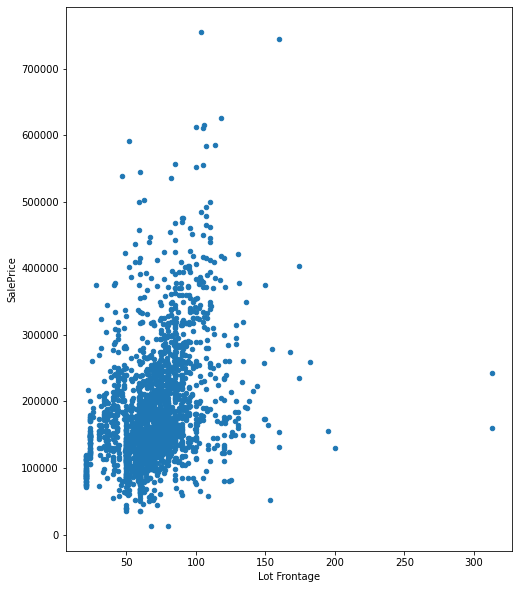

Lot Area


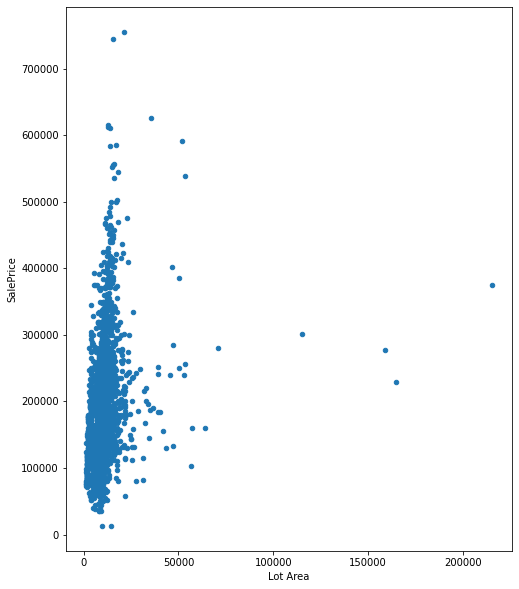

Year Built


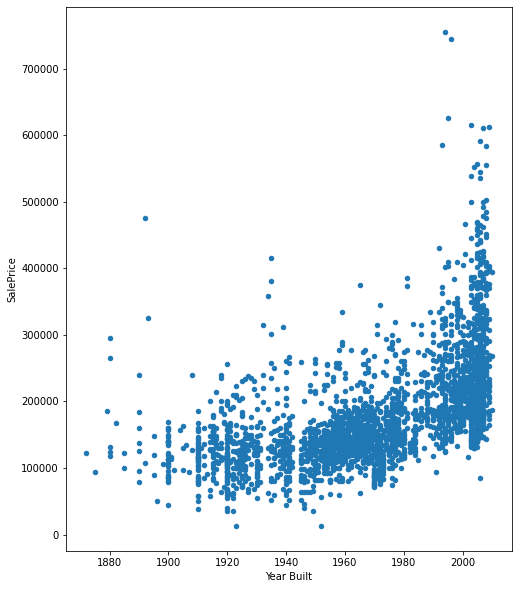

Year Remod/Add


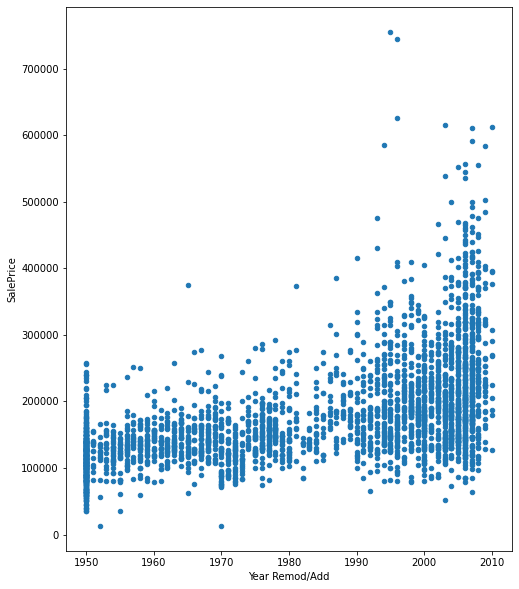

Mas Vnr Area


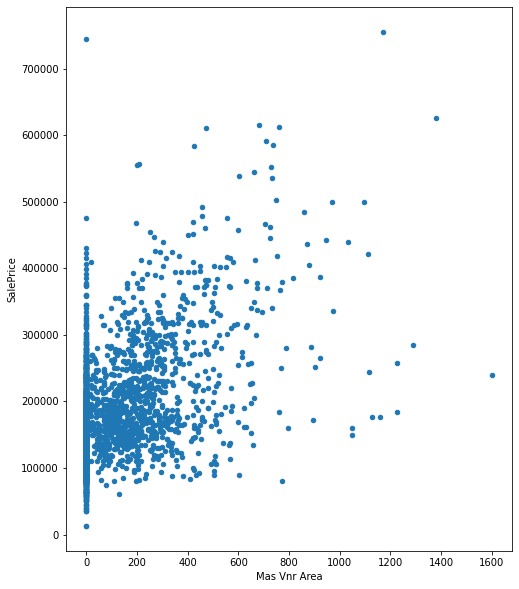

BsmtFin SF 1


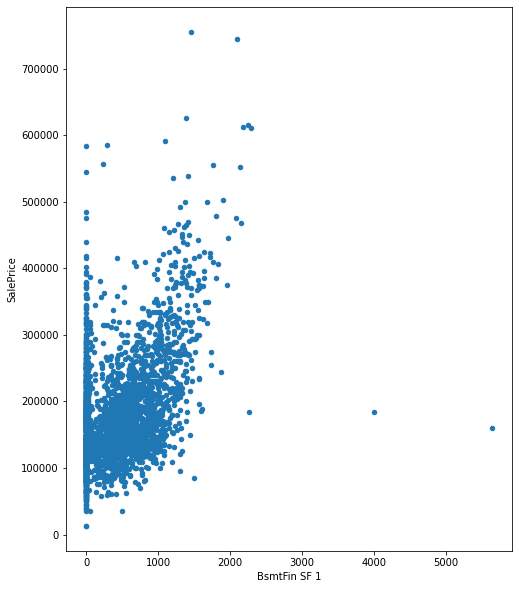

BsmtFin SF 2


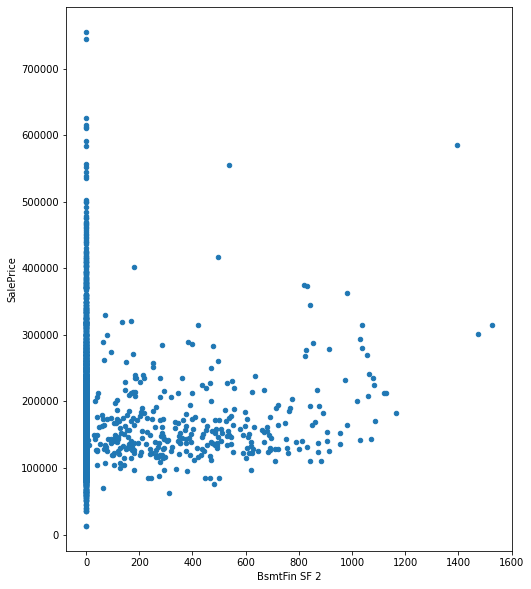

Bsmt Unf SF


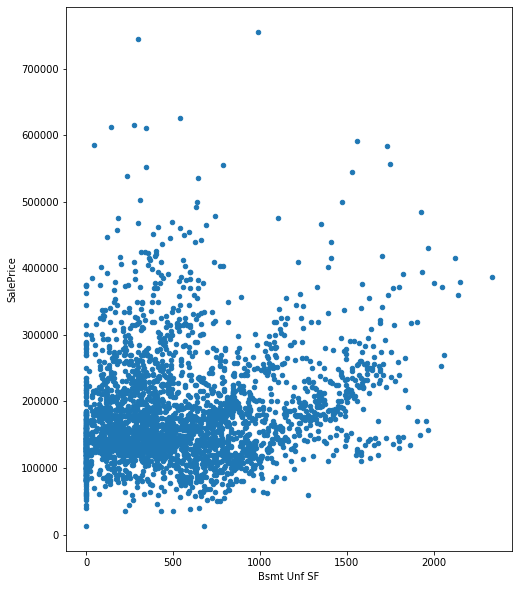

Total Bsmt SF


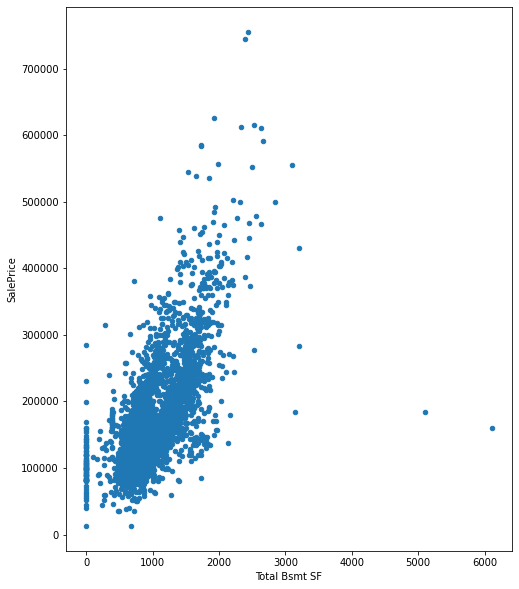

1st Flr SF


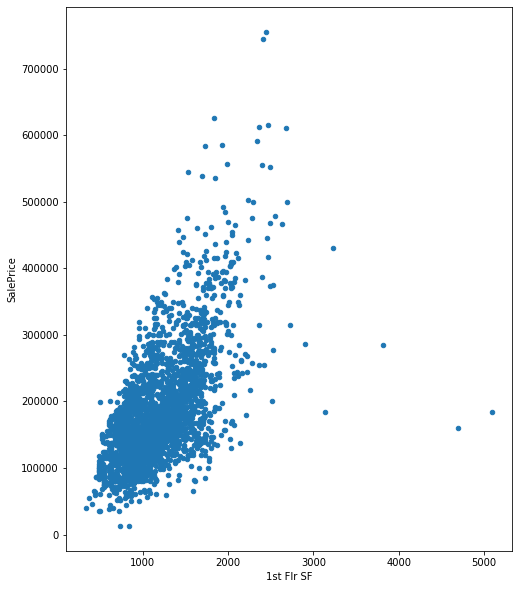

2nd Flr SF


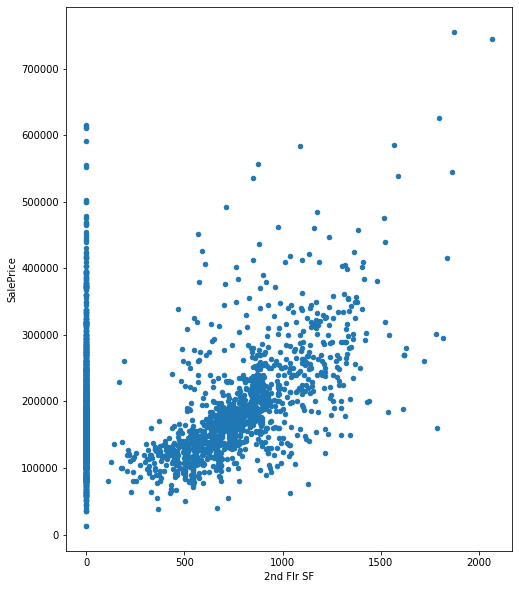

Low Qual Fin SF


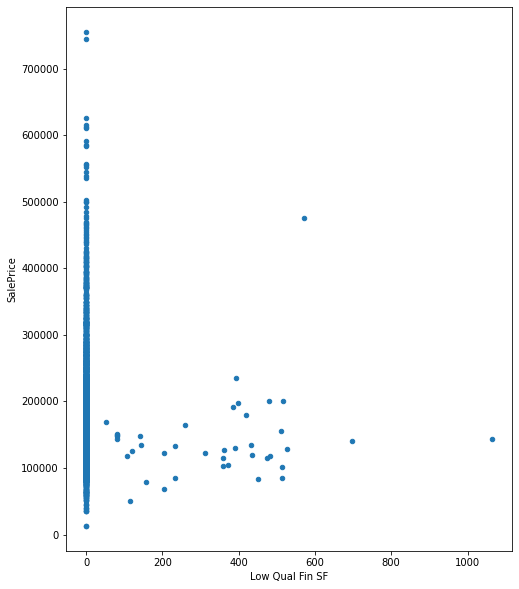

Gr Liv Area


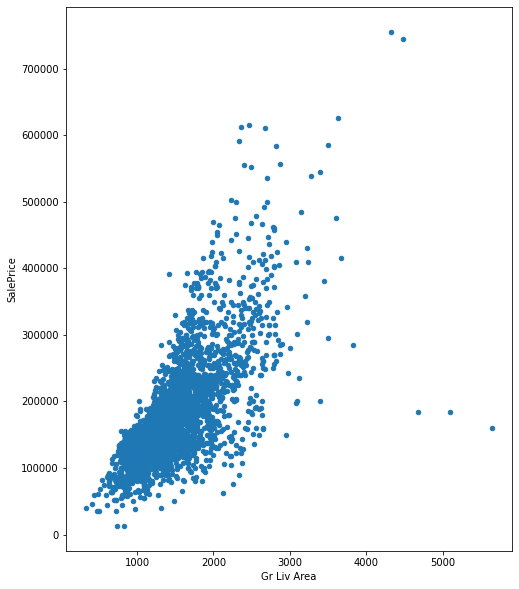

Bsmt Full Bath


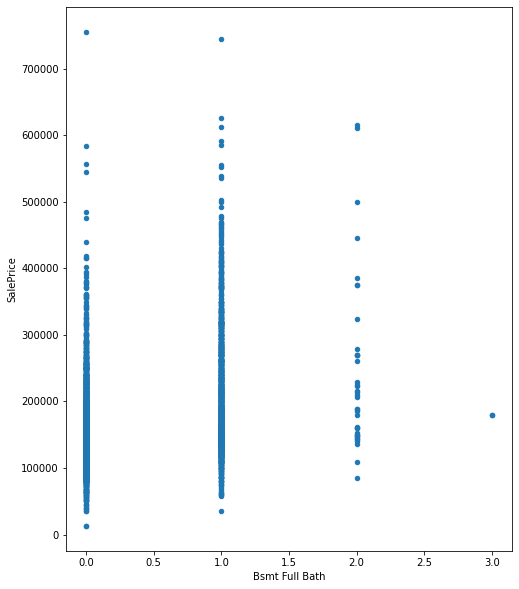

Bsmt Half Bath


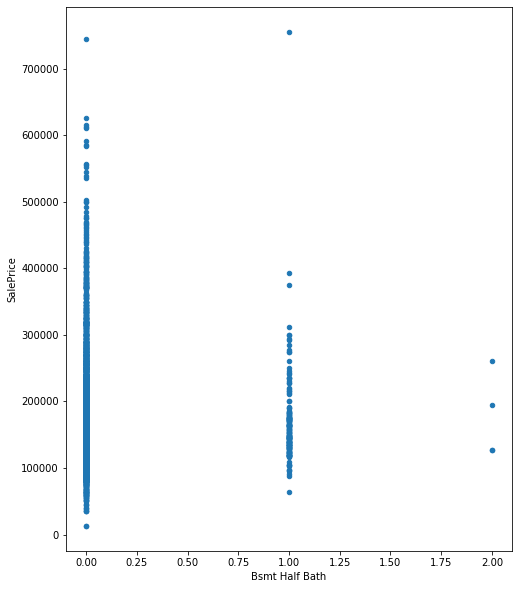

Full Bath


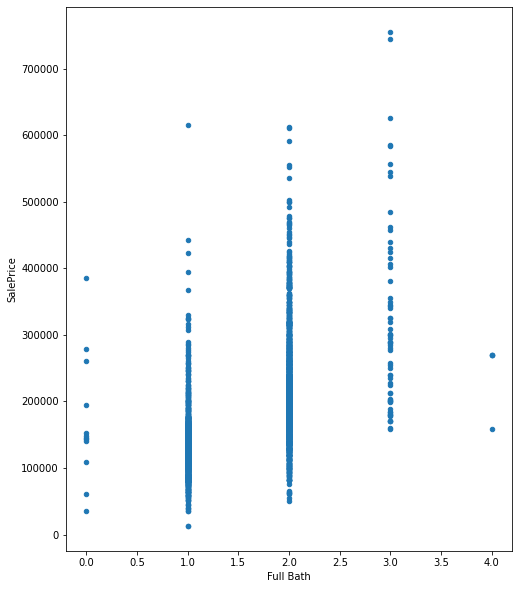

Half Bath


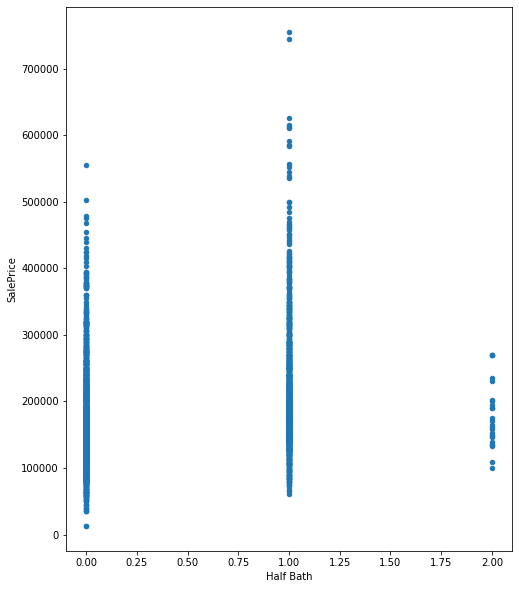

Bedroom AbvGr


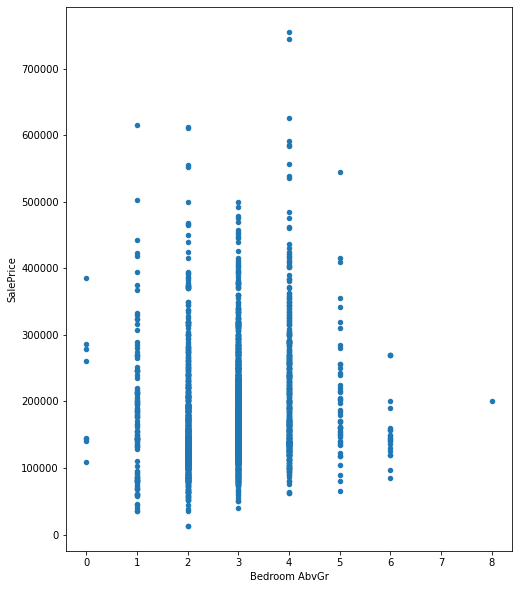

Kitchen AbvGr


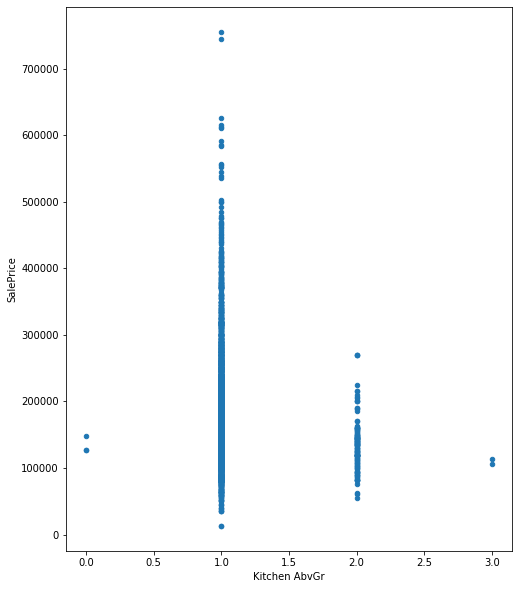

TotRms AbvGrd


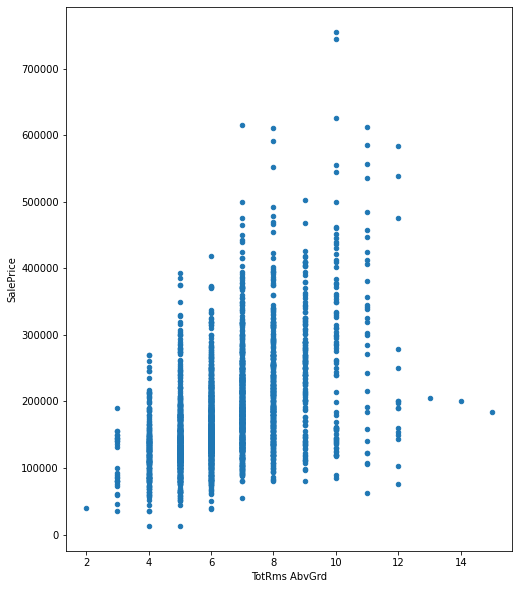

Fireplaces


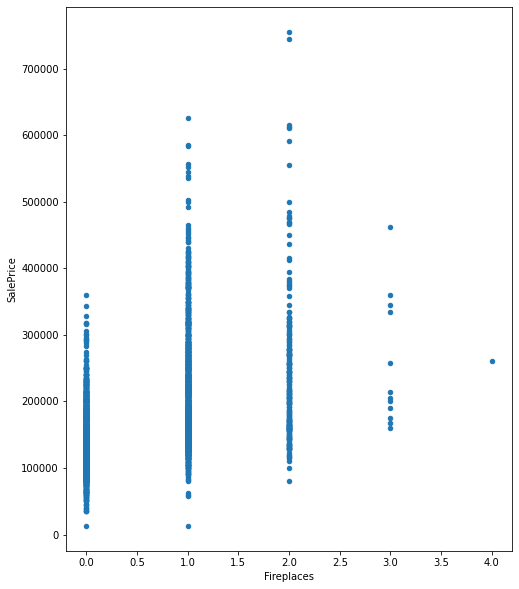

Garage Yr Blt


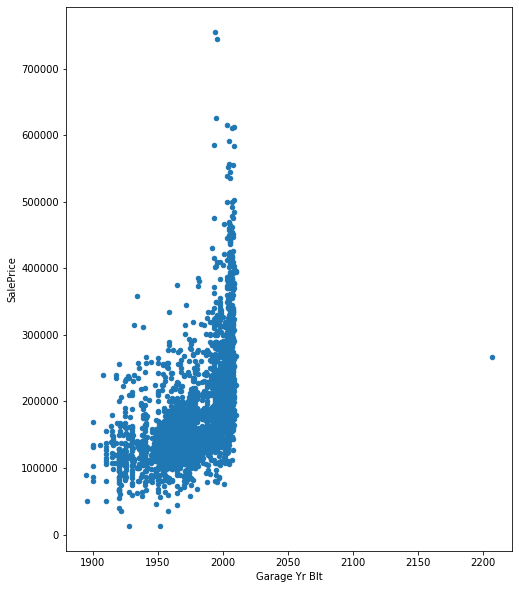

Garage Cars


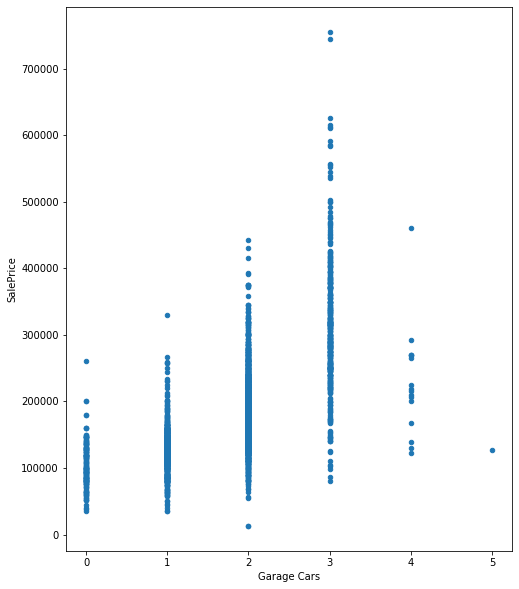

Garage Area


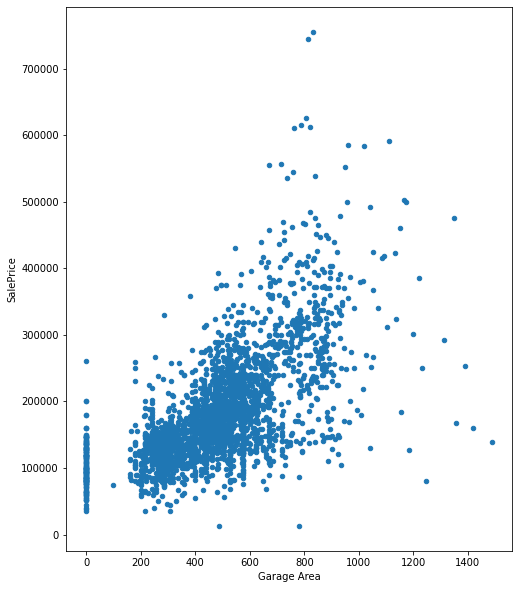

Wood Deck SF


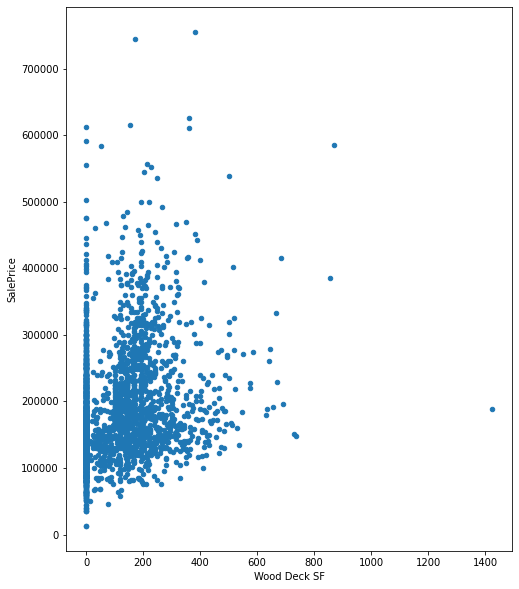

Open Porch SF


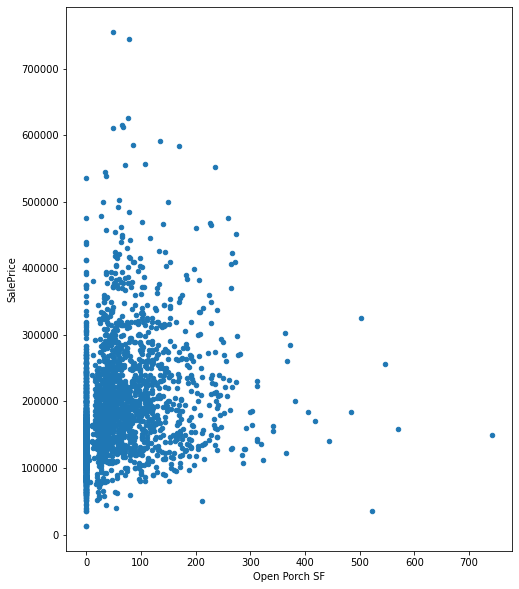

Enclosed Porch


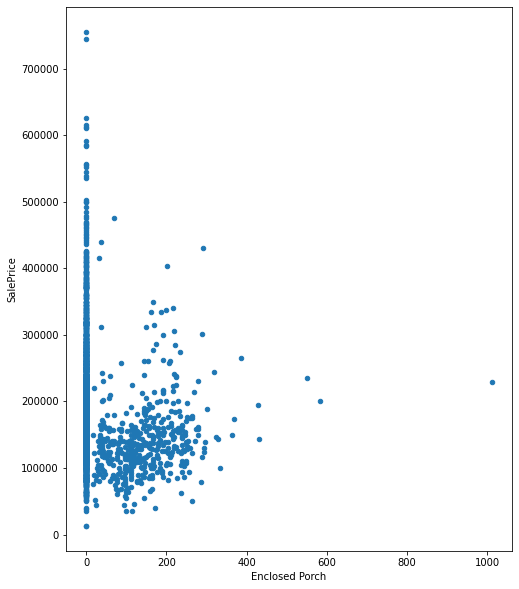

3Ssn Porch


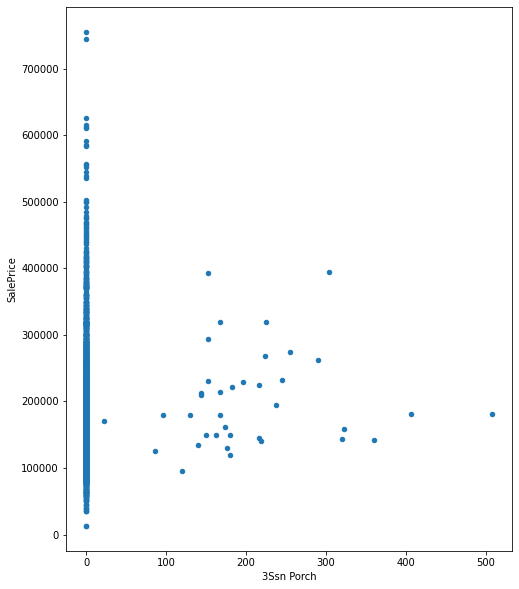

Screen Porch


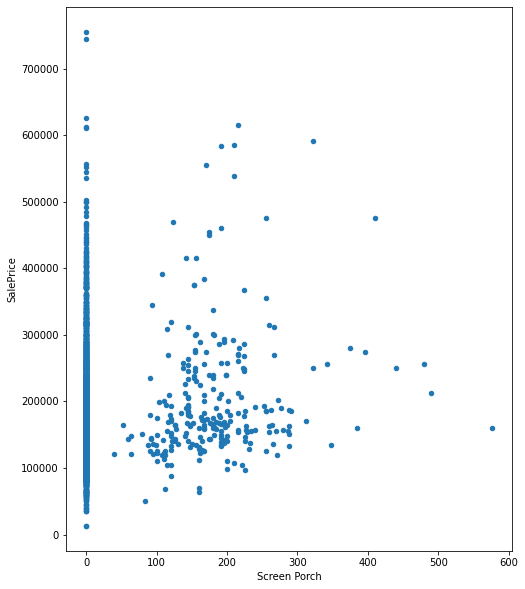

Pool Area


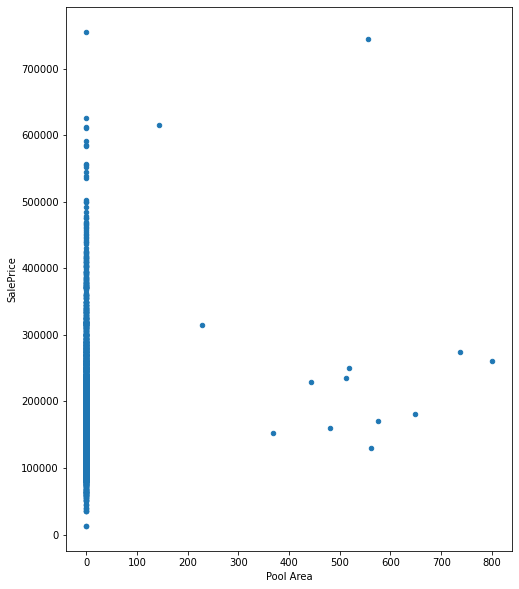

Misc Val


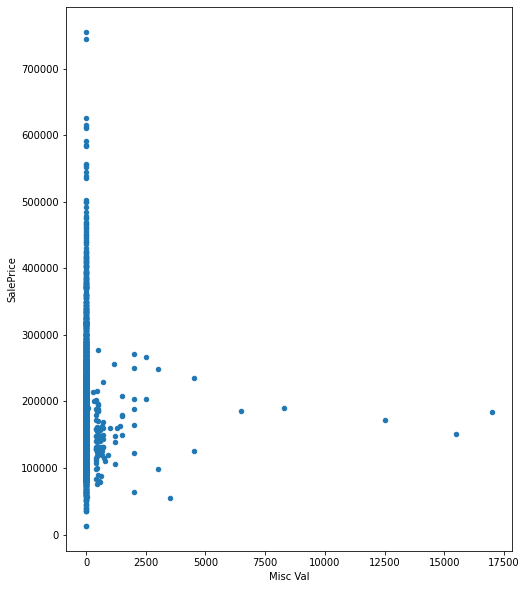

Mo Sold


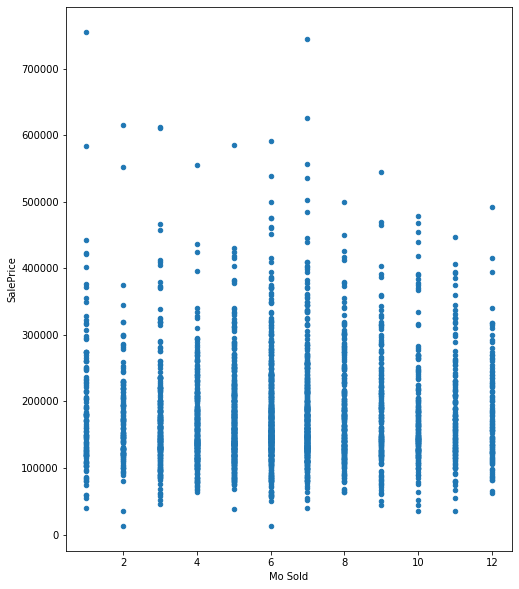

Yr Sold


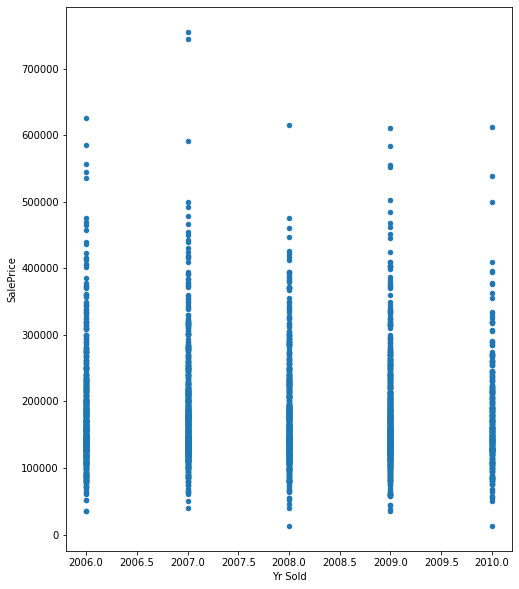

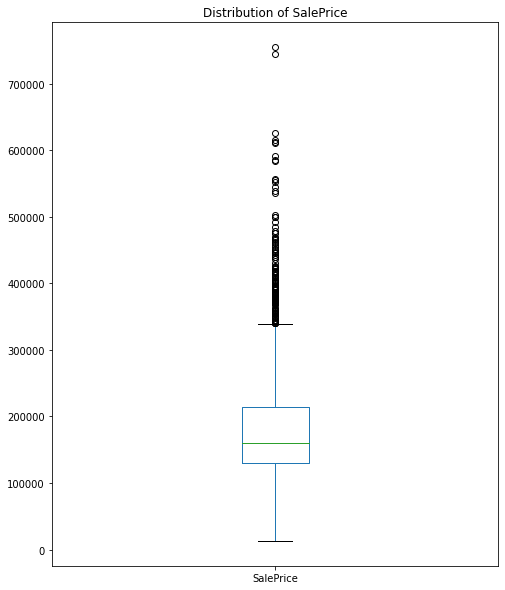

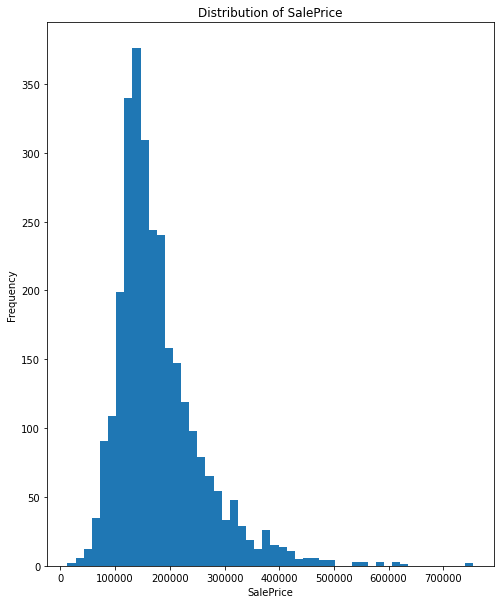

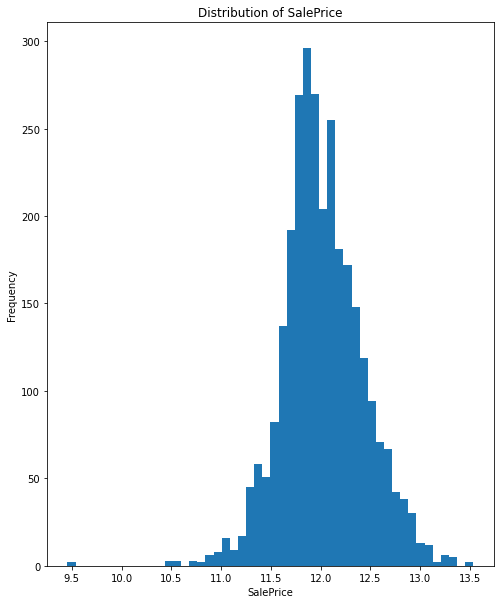

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from scipy import stats
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import \
    variance_inflation_factor
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot

from sklearn.model_selection import cross_val_score, \
    GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import ElasticNetCV, LassoCV, ElasticNet, Lasso,Ridge
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsRegressor


url='http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls'
housing = pd.read_excel(url)

housing = housing.iloc[:, 2:]
print(housing.info())

transform_rate={1:'Very Poor',2:'Poor',3:'Fair',4:'Below Average',
                5:'Average', 6:'Above Average',7:'Good',8:'Very Good',
                9:'Excellent',10:'Very Excellent'}

transform_subclass={20:'1-STORY 1946 & NEWER ALL STYLES',30:'1-STORY 1945 & '
                    'OLDER', 40:'1-STORY W/FINISHED ATTIC ALL AGES',
                    45:'1-1/2 STORY - UNFINISHED ALL AGES', 50:'1-1/2 STORY '
                    'FINISHED ALL AGES',60:'2-STORY 1946 & NEWER',
                    70:'2-STORY 1945 & OLDER',75:'2-1/2 STORY ALL AGES',
                    80:'SPLIT OR MULTI-LEVEL',85:'SPLIT FOYER', 90:'DUPLEX - '
                    'ALL STYLES AND AGES',120:'1-STORY PUD (Planned Unit '
                                              'Development) - 1946 & NEWER',
                    150:'1-1/2 STORY PUD - ALL AGES',160:'2-STORY PUD - 1946 '
                    '& NEWER',180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
                    190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'}

housing['Overall Qual'] = housing['Overall Qual'].map(transform_rate)
housing['Overall Cond'] = housing['Overall Cond'].map(transform_rate)
housing['MS SubClass'] = housing['MS SubClass'].map(transform_subclass)


housing['Overall Qual'] = housing['Overall Qual'].astype(CategoricalDtype(
    categories = ['Very Poor','Poor','Fair','Below Average',
                'Average', 'Above Average','Good','Very Good',
                'Excellent','Very Excellent'],ordered=True))
housing['Overall Cond'] = housing['Overall Cond'].astype(CategoricalDtype(
    categories = ['Very Poor','Poor','Fair','Below Average',
                'Average', 'Above Average','Good','Very Good',
                'Excellent','Very Excellent'],ordered=True))


housing = housing.drop(
    ['Alley', 'Pool QC', 'Fence', 'Misc Feature', 'Fireplace Qu'], axis=1)

# Change categorical variables from object type to category type
for column in housing.select_dtypes(['object']).columns:
    housing[column] = housing[column].astype('category')


print(housing.info())

columns = list(housing.iloc[:, :-1].columns)
for column in columns:
    if str(housing[column].dtypes) != 'category':
        housing.plot(kind='scatter', x=column, y='SalePrice')
        print(column)
        plt.show()

housing.SalePrice.plot(kind='box')
plt.title('Distribution of SalePrice')
plt.show()

housing.SalePrice.plot(kind='hist',bins=50)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.show()

# logarithm transformation
housing.SalePrice=np.log(housing.SalePrice)
housing.SalePrice.plot(kind='hist',bins=50)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.show()


# housing = housing.sort_values(by=['Yr Sold', 'Mo Sold'])
# housing.reset_index(drop=True, inplace=True)



# 5 training and test splits
housing['YearMonth'] = housing['Yr Sold'] * 100 + housing['Mo Sold']
print(housing.head())


def training_test_split(start_date, end_date):
    train = housing[housing['YearMonth'] < start_date].drop(['YearMonth'],
                                                            axis=1)
    test = housing[(housing['YearMonth'] >= start_date) & (housing[
                                                               'YearMonth'] < end_date)].drop(
        ['YearMonth'], axis=1)
    # These NA's indicate that the house just doesn't have it
    empty_means_without = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
                           'BsmtFin Type 1',
                           'BsmtFin Type 2',
                           'Garage Type', 'Garage Finish', 'Garage Qual',
                           'Garage '
                           'Cond']
    for feature in empty_means_without:
        train[feature].cat.add_categories(['None'], inplace=True)
        train[feature].fillna('None', inplace=True)
    train['Mas Vnr Type'].fillna('None', inplace=True)
    train['Mas Vnr Area'].fillna(0, inplace=True)
    # Replace NA's in numeric variables with the mean
    train['Lot Frontage'].fillna(train['Lot Frontage'].mean(), inplace=True)
    train['Garage Yr Blt'][train['Garage Yr Blt'] == 2207] = 2007
    train['Garage Yr Blt'][train['Garage Cars'] == 0].fillna(2999, inplace=True)

    train.dropna(inplace=True)  # Drop any remaining NA's

    print(train.info())

    return (train, test)



train_1, test_1 = training_test_split(200804, 200904)
train_2, test_2 = training_test_split(200807, 200907)
train_3, test_3 = training_test_split(200810, 200910)
train_4, test_4 = training_test_split(200901, 201001)
train_5, test_5 = training_test_split(200904, 201004)
train_6, test_6 = training_test_split(200907, 201007)


def linear_regression_assumptions(features, label, feature_names=None):
    """
    Tests a linear regression on the model to see if assumptions are being met
    """

    # Setting feature names to x1, x2, x3, etc. if they are not defined
    if feature_names is None:
        feature_names = ['X' + str(feature + 1) for feature in
                         range(features.shape[1])]

    print('Fitting linear regression')
    # generate OLS model
    model = sm.OLS(label, sm.add_constant(features))
    model_fit = model.fit()


    print('\nPerforming linear regression assumption testing')

    # Creating predictions and calculating residuals for assumption tests
    predictions = model_fit.fittedvalues
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})

    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    def linear_assumption():
        """
        Linearity: Assumes there is a linear relationship between the predictors and
                   the response variable.

        """
        print(
            '\n=======================================================================================')
        print(
            'Assumption 1: Linear Relationship between the Target and the Features')

        print(
            'Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.')

        # Plotting the actual vs predicted values
        sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False,
                   height=7)

        # Plotting the diagonal line
        line_coords = np.arange(df_results.min().min(), df_results.max().max())
        plt.plot(line_coords, line_coords,  # X and y points
                 color='darkorange', linestyle='--')
        plt.title('Actual vs. Predicted')
        plt.show()
        print('If non-linearity is apparent, consider adding a polynomial term')

    def normal_errors_assumption(p_value_thresh=0.05):
        """
        Normality: Assumes that the error terms are normally distributed. If they are not,
        nonlinear transformations of variables may solve this.

        """

        print(
            '\n=======================================================================================')
        print('Assumption 2: The error terms are normally distributed')
        print()

        # Plotting the residuals distribution
        plt.subplots(figsize=(12, 6))
        plt.title('Distribution of Residuals')
        sns.distplot(model_residuals)
        plt.show()

        QQ = ProbPlot(model_norm_residuals)
        plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
        plot_lm_2.axes[0].set_title('Normal Q-Q')
        plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
        plot_lm_2.axes[0].set_ylabel('Standardized Residuals')
        plt.show()

    def multicollinearity_assumption():
        """
        Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                           correlation among the predictors, then either remove prepdictors with high
                           Variance Inflation Factor (VIF) values or perform dimensionality reduction

        """

        print(
            '\n=======================================================================================')
        print('Assumption 3: Little to no multicollinearity among predictors')
        print('Variance Inflation Factors (VIF)')
        print('> 10: An indication that multicollinearity may be present')
        print('> 100: Certain multicollinearity among the variables')
        print('-------------------------------------')

        # Gathering the VIF for each variable
        VIF = [variance_inflation_factor(features, i) for i in
               range(features.shape[1])]
        for idx, vif in enumerate(VIF):
            print('{0}: {1}'.format(feature_names[idx], vif))

        # Gathering and printing total cases of possible or definite multicollinearity
        possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
        definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
        print()
        print('{0} cases of possible multicollinearity'.format(
            possible_multicollinearity))
        print('{0} cases of definite multicollinearity'.format(
            definite_multicollinearity))
        print()

        if definite_multicollinearity == 0:
            if possible_multicollinearity == 0:
                print('Assumption satisfied')
            else:
                print('Assumption possibly satisfied')
                print()
                print('Coefficient interpretability may be problematic')
                print(
                    'Consider removing variables with a high Variance Inflation Factor (VIF)')
        else:
            print('Assumption not satisfied')
            print()
            print('Coefficient interpretability will be problematic')
            print(
                'Consider removing variables with a high Variance Inflation Factor (VIF)')

    def autocorrelation_assumption():
        """
        Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                         autocorrelation, then there is a pattern that is not explained due to
                         the current value being dependent on the previous value.

        """

        print(
            '\n=======================================================================================')
        print('Assumption 4: No Autocorrelation')
        print('\nPerforming Durbin-Watson Test')
        print(
            'Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
        print('0 to 2< is positive autocorrelation')
        print('>2 to 4 is negative autocorrelation')
        print('-------------------------------------')
        durbinWatson = durbin_watson(model_residuals)
        print('Durbin-Watson:', durbinWatson)
        if durbinWatson < 1.5:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        elif durbinWatson > 2.5:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        else:
            print('Little to no autocorrelation', '\n')
            print('Assumption satisfied')

    def homoscedasticity_assumption():
        """
        Homoscedasticity: Assumes that the errors exhibit constant variance

        """
        print(
            '\n=======================================================================================')
        print('Assumption 5: Homoscedasticity of Error Terms')
        print('Residuals should have relative constant variance')

        # Plotting the residuals
        plt.subplots(figsize=(12, 6))
        ax = plt.subplot(111)  # To remove spines
        plt.scatter(x=df_results.index, y=model_residuals, alpha=0.5)
        plt.plot(np.repeat(0, df_results.index.max()), color='darkorange',
                 linestyle='--')
        ax.spines['right'].set_visible(False)  # Removing the right spine
        ax.spines['top'].set_visible(False)  # Removing the top spine
        plt.title('Residuals')
        plt.show()
        print(
            'If heteroscedasticity is apparent, confidence intervals and predictions will be affected')

    linear_assumption()
    normal_errors_assumption()
    multicollinearity_assumption()
    autocorrelation_assumption()
    homoscedasticity_assumption()


def pearson_corr_fs(data):
    # Using Pearson Correlation
    cor = data.corr()
    # Correlation with output variable
    cor_target = abs(cor["SalePrice"])
    # Selecting highly correlated features
    relevant_features = cor_target[cor_target > 0.5]
    print(relevant_features)
    # print(relevant_features.index)
    # # features highly correlated with target variable
    df_corr = data[relevant_features.index]
    # Compute the correlation matrix

    corr = df_corr.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()
    # remove highly correlated features
    # Create correlation matrix
    corr_matrix = df_corr.drop('SalePrice',axis=1).corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find features with correlation greater than 0.8
    to_drop = [column for column in upper.columns if any(upper[column] >=0.8)]
    # Drop features
    df_selected=df_corr.drop(to_drop, axis=1)
    df_selected.drop('Year Remod/Add', axis=1, inplace=True)
    return df_selected



def linear_regression(data, t):
    X = data.drop('SalePrice', axis=1)
    y = data.SalePrice
    X_test = t.drop('SalePrice', axis=1)
    y_test = t.SalePrice
    linear_reg = LinearRegression()
    MSEs = cross_val_score(linear_reg, X, y,
                           scoring='neg_mean_squared_error', cv=10)
    MSE = np.median(MSEs)
    print('Mean Squared Error:', MSE)
    linear_reg.fit(X, y)
    y_pred = linear_reg.predict(X_test)
    lin_r2 = r2_score(y_test,y_pred)
    lin_mse = mean_squared_error(y_test,y_pred)
    lin_mae = mean_absolute_error(y_test,y_pred)
    lin_v = explained_variance_score(y_test,y_pred)
    return lin_mse, lin_r2,lin_mae,lin_v


def knn_stepwise_fs(data):
    X = data.drop('SalePrice', axis=1)
    y = data.SalePrice
    knn = KNeighborsRegressor(n_neighbors=3)
    sfs = SequentialFeatureSelector(knn,
              k_features=10,
              forward=True,
              floating=False,
              scoring='neg_mean_squared_error',
              cv=10)
    sfs.fit(X, y)
    print('Selected features:', sfs.k_feature_names_)
    print('Mean Squared Error:', abs(sfs.k_score_))
    selected_features = list(sfs.k_feature_names_)
    return selected_features


def knn_regression(X, y, X_test, y_test):
    knn = KNeighborsRegressor()
    parameter = {'n_neighbors': [2,3,4,5,6]}

    knn_reg = GridSearchCV(knn,
                      param_grid=parameter,
                      scoring='neg_mean_squared_error',
                      cv=10)
    knn_reg.fit(X, y)
    print('Best parameter:',knn_reg.best_params_)
    print('Mean Squared Error:',abs(knn_reg.best_score_))

    knn = KNeighborsRegressor(n_neighbors = knn_reg.best_params_['n_neighbors'])


    knn.fit(X,y)
    y_pred = knn.predict(X_test)
    knn_r2 = r2_score(y_test,y_pred)
    knn_mse = mean_squared_error(y_test,y_pred)
    knn_mae = mean_absolute_error(y_test,y_pred)
    knn_v = explained_variance_score(y_test,y_pred)

    return knn_mse, knn_r2,knn_mae,knn_v


def ols_regression(data, t):
    X = data.drop('SalePrice', axis=1)
    y = data.SalePrice
    X_test = t.drop('SalePrice', axis=1)
    y_test = t.SalePrice
    ols_reg = sm.OLS(y, sm.add_constant(X)).fit()
    y_pred = ols_reg.predict(sm.add_constant(X_test))
    lin_r2 = r2_score(y_test,y_pred)
    lin_mse = mean_squared_error(y_test,y_pred)
    lin_mae = mean_absolute_error(y_test,y_pred)
    lin_v = explained_variance_score(y_test,y_pred)
    return lin_mse, lin_r2,lin_mae,lin_v


def lasso_fs(data):
    # Lasso
    X = data.drop('SalePrice', axis=1)
    y = data.SalePrice
    reg = LassoCV()
    reg.fit(X, y)
    print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
    print("Best score using built-in LassoCV: %f" % reg.score(X, y))
    coef = pd.Series(reg.coef_, index=X.columns)

    print("Lasso picked " + str(
        sum(coef != 0)) + " variables and eliminated the other " + str(
        sum(coef == 0)) + " variables")
    imp_coef = coef[coef != 0].sort_values()
    print('Variables  Coefficient')
    print(imp_coef)
    plt.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef.plot(kind="barh")
    plt.title("Feature importance using Lasso Model")
    plt.show()
    return imp_coef.index.values.tolist()


def lasso_regression(X, y, X_test, y_test):
    # X = data.drop('SalePrice', axis=1)
    # y = data.SalePrice
    lasso = Lasso()
    parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
    lasso_reg = GridSearchCV(lasso, parameters,
                             scoring='neg_mean_squared_error',
                             cv=10)
    lasso_reg.fit(X, y)

    print('Best parameter:',lasso_reg.best_params_)
    print('Mean Squared Error:',abs(lasso_reg.best_score_))

    lasso = Lasso(alpha=lasso_reg.best_params_['alpha'])

    lasso.fit(X, y)
    y_pred = lasso.predict(X_test)
    lasso_r2 = r2_score(y_test,y_pred)
    lasso_mse = mean_squared_error(y_test,y_pred)
    lasso_mae = mean_absolute_error(y_test,y_pred)
    lasso_v = explained_variance_score(y_test,y_pred)
    return lasso_mse, lasso_r2,lasso_mae,lasso_v


def elasticnet_fs(data):
    # elasticnet
    X = data.drop('SalePrice', axis=1)
    y = data.SalePrice
    reg = ElasticNetCV()
    reg.fit(X, y)
    print("Best alpha using built-in ElasticNetCV: %f" % reg.alpha_)
    print("Best score using built-in ElasticNetCV: %f" % reg.score(X, y))
    coef = pd.Series(reg.coef_, index=X.columns)

    print("ElasticNet picked " + str(
        sum(coef != 0)) + " variables and eliminated the other " + str(
        sum(coef == 0)) + " variables")
    imp_coef = coef[coef != 0].sort_values()
    print('Variables  Coefficient')
    print(imp_coef)
    plt.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef.plot(kind="barh")
    plt.title("Feature importance using ElasticNet Model")
    plt.show()
    return imp_coef.index.values.tolist()


def elasticnet_regression(X, y, X_test, y_test):
    # X = data.drop('SalePrice', axis=1)
    # y = data.SalePrice
    elasticnet = ElasticNet()
    parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
    elasticnet_reg = GridSearchCV(elasticnet, parameters,
                             scoring='neg_mean_squared_error',
                             cv=10)
    elasticnet_reg.fit(X, y)

    print('Best parameter:',elasticnet_reg.best_params_)
    print('Mean Squared Error:',abs(elasticnet_reg.best_score_))

    elasticnet = ElasticNet(alpha=elasticnet_reg.best_params_['alpha'])

    elasticnet.fit(X, y)
    y_pred = elasticnet.predict(X_test)
    elasticnet_r2 = r2_score(y_test,y_pred)
    elasticnet_mse = mean_squared_error(y_test,y_pred)
    elasticnet_mae = mean_absolute_error(y_test,y_pred)
    elasticnet_v = explained_variance_score(y_test,y_pred)
    return elasticnet_mse, elasticnet_r2,elasticnet_mae,elasticnet_v


def randomforest_fs(data):
    X = data.drop('SalePrice', axis=1)
    y = data.SalePrice
    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators=500)
    # Train the model on training data
    rf.fit(X, y)
    # Get numerical feature importances
    feature_list = X.columns
    importances = list(rf.feature_importances_)
    # List of tuples with variable and importance
    print('Variables  Importance')
    feature_importances = [(feature, round(importance, 2)) for
                           feature, importance in
                           zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key=lambda x: x[1],
                                 reverse=True)
    selected_features = []
    # Print out the feature and importances
    for pair in feature_importances:
        if pair[1] > 0.01:
            print('Variable: {:25} Importance: {}'.format(
                *pair))
            selected_features.append(pair[0])
    return selected_features


def randomforest_regression(X, y, X_test, y_test):
    # X = data.drop('SalePrice', axis=1)
    # y = data.SalePrice
    rf = RandomForestRegressor()
    parameters = {'n_estimators': [100, 200, 300, 500, 1000]}
    rf_reg = GridSearchCV(rf, parameters,
                          scoring='neg_mean_squared_error',
                          cv=10)
    rf_reg.fit(X, y)

    print('Best parameter:',rf_reg.best_params_)
    print('Mean Squared Error:',abs(rf_reg.best_score_))

    rf = RandomForestRegressor(n_estimators=rf_reg.best_params_['n_estimators'])

    rf.fit(X, y)
    y_pred = rf.predict(X_test)
    rf_r2 = r2_score(y_test,y_pred)
    rf_mse = mean_squared_error(y_test,y_pred)
    rf_mae = mean_absolute_error(y_test,y_pred)
    rf_v = explained_variance_score(y_test,y_pred)
    return rf_mse, rf_r2,rf_mae,rf_v



def regression_model(dataset,test):
    test_result = pd.DataFrame(columns=['mse', 'r2', 'mae', 'v'])
    # linear regression
    print(
        '\n=======================================================================================')
    print('Linear Regression')
    print(
        '\n=======================================================================================')
    cor_list = list(dataset.columns)
    cor_list.remove('SalePrice')
    cor_list.append('SalePrice')
    df_linear = pearson_corr_fs(dataset.reindex(columns=cor_list))
    print('Selected Feature:',df_linear.drop('SalePrice',
            axis=1).columns)
    test_linear = test[list(df_linear.columns)]
    test_linear.dropna(inplace=True)
    test_linear = test_linear.sample(n=450)
    test_result.loc['linear_regression', 'mse'], test_result.loc[
        'linear_regression', 'r2'],test_result.loc['linear_regression', 'mae'], \
    test_result.loc['linear_regression', 'v'] = linear_regression(df_linear,
                                                                 test_linear)
    linear_regression_assumptions(df_linear.drop('SalePrice', axis=1).values,
                                  df_linear.SalePrice.values, df_linear.drop(
            'SalePrice',
            axis=1).columns)


    # knn regression
    print(
        '\n=======================================================================================')
    print('KNN Regression')
    print(
        '\n=======================================================================================')
    selected_features=knn_stepwise_fs(dataset)
    df_knn = dataset[selected_features]
    selected_features.append('SalePrice')
    test_knn = test[selected_features]
    test_knn.dropna(inplace=True)
    test_knn = test_knn.sample(n=450)

    test_result.loc['knn_regression', 'mse'], test_result.loc[
        'knn_regression', 'r2'],test_result.loc['knn_regression', 'mae'], \
    test_result.loc['knn_regression', 'v'] = knn_regression(df_knn,
                                              dataset.SalePrice,
                                test_knn.drop('SalePrice', axis=1),
                                test_knn['SalePrice'])



    # lasso regression
    print(
        '\n=======================================================================================')
    print('Lasso Regression')
    print(
        '\n=======================================================================================')
    df_lasso = dataset[lasso_fs(dataset)]
    test_columns = list(df_lasso.columns)
    test_columns.append('SalePrice')
    test_lasso = test[test_columns]
    test_lasso.dropna(inplace=True)
    test_lasso = test_lasso.sample(n=450)
    test_result.loc['lasso_regression', 'mse'], test_result.loc['lasso_regression',
                                                              'r2'], \
    test_result.loc['lasso_regression', 'mae'], test_result.loc['lasso_regression',
                                                              'v'] = \
        lasso_regression(df_lasso,
                         dataset.SalePrice, test_lasso.drop('SalePrice', axis=1),
                         test_lasso['SalePrice'])

    # elasticnet regression
    print(
        '\n=======================================================================================')
    print('ElasticNet Regression')
    print(
        '\n=======================================================================================')
    df_elasticnet = dataset[elasticnet_fs(dataset)]
    test_columns = list(df_elasticnet.columns)
    test_columns.append('SalePrice')
    test_elasticnet = test[test_columns]
    test_elasticnet.dropna(inplace=True)
    test_elasticnet = test_elasticnet.sample(n=450)
    test_result.loc['elasticnet_regression', 'mse'], test_result.loc['elasticnet_regression',
                                                              'r2'], \
    test_result.loc['elasticnet_regression', 'mae'], test_result.loc['elasticnet_regression',
                                                              'v'] = \
        elasticnet_regression(df_elasticnet,
                         dataset.SalePrice, test_elasticnet.drop('SalePrice', axis=1),
                         test_elasticnet['SalePrice'])

    # RandomForest
    print(
        '\n=======================================================================================')
    print('Random Forest Regression')
    print(
        '\n=======================================================================================')
    df_random_forest = dataset[randomforest_fs(dataset)]
    test_columns = list(df_random_forest.columns)
    test_columns.append('SalePrice')
    test_random_forest = test[test_columns]
    test_random_forest.dropna(inplace=True)
    test_random_forest = test_random_forest.sample(n=450)
    test_result.loc['random_forest_regression', 'mse'], test_result.loc[
        'random_forest_regression', 'r2'], test_result.loc[
        'random_forest_regression', 'mae'], test_result.loc[
        'random_forest_regression', 'v'] = \
        randomforest_regression(df_random_forest, dataset.SalePrice,
                                test_random_forest.drop('SalePrice', axis=1),
                                test_random_forest['SalePrice'])
    print(test_result)



regression_model(pd.get_dummies(train_1),pd.get_dummies(test_1))
regression_model(pd.get_dummies(train_2),pd.get_dummies(test_2))
regression_model(pd.get_dummies(train_3),pd.get_dummies(test_3))
regression_model(pd.get_dummies(train_4),pd.get_dummies(test_4))
regression_model(pd.get_dummies(train_5),pd.get_dummies(test_5))
regression_model(pd.get_dummies(train_6),pd.get_dummies(test_6))
